![IonQ Logo](./IonQCV/logo.png)

# 👋 Welcome to IonQ's **Quantum Computer Vision** challenge, hosted by SCQ!
*by Willie Aboumrad, Vadim Karpusenko, and Heidi Nelson-Quillin*

Image classification is a key task in computer vision, with researchers continually improving models to achieve higher accuracy on standardized benchmarks. Recently, quantum computing methods have also been introduced as potential solutions, or part of these.

In this challenge, you'll take on the role of an IonQ Apps Team scientist, exploring image classification through quantum machine learning (QML) techniques.

<video controls src="./IonQCV/ion_trap_animation.mp4" width=90%; autoplay> </video>

We will tackle a binary classification problem, challenging you to design a hybrid classical-quantum neural network aimed at achieving the highest possible classification accuracy.

To assist you, we’ve provided exclusive access to unreleased features of IonQ’s next-generation SDK, which will handle the orchestration and the classical components of the hybrid pipeline. This allows you to concentrate on the most intriguing, purely quantum tasks:

- 🖼️ Encoding image data onto a quantum backend using an encoding circuit,
- ⚛️🧩 Differentiating encoded state vectors via a trainable ansatz, and
- 📊 Extracting relevant features for classification by measuring a set of observables.

Before you begin, remember to activate the "IonQ Vision Challenge" environment on the qBraid platform and switch to that kernel. If you encounter any issues at this stage, do not hesitate to ask for help.

![ENVS](./IonQCV/qBraid.png)

# 🕵️‍♂️ Your mission, should you choose to accept it

In this challenge, you'll build a hybrid quantum-classical image classification pipeline using <span style="color:purple">ionqvision</span>, IonQ’s next-generation platform for QML computations, along with [PyTorch](https://pytorch.org/). Specifically, you'll train a quantum-classical neural network to differentiate between two distinct types of handwritten digits from the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset.

<div class="alert alert-block alert-info">
<b>💡 Tip:</b> If you're new to <span style="color:purple">PyTorch</span>, no worries!

This challenge is all about the **quantum** in [Quantum Machine Learning](https://en.wikipedia.org/wiki/Quantum_machine_learning). The provided starter code takes care of all the setup, allowing you to concentrate on designing your best quantum circuits!</div>

The figure below showcases our hybrid pipeline, with the operations inside the gray box representing the quantum layer — where all the magic happens.

![hubrid neural network topology](./IonQCV/hybrid_nn.png)

*<p style="text-align: center;">Figure 1: A diagrammatic representation of our hybrid quantum-classical image classification pipeline</p>*

Your mission, should you choose to accept it, is to design the quantum layer that achieves **the highest possible classification accuracy**, which will be automatically scored on an unseen validation set. Sounds simple, right?

## 🎻 ⚛ 🎻 Classical, quantum, and then classical again

If you’ve made it thus far, congratulations! 🎉

You're about to embark on an exciting journey of quantum exploration. To start, we’ll dive into the architecture of our hybrid neural network. It's important to remember that running the full *hybrid* pipeline involves **both** classical and quantum hardware, along with software that enables communication between them. Fortunately, <span style="color:purple">ionqvision</span> simplifies much of this complexity, allowing you to focus on the quantum design.

In the following sections, we’ll break down the classical and quantum components of the pipeline in more detail. After that, we’ll guide you through the starter code so you can get up and running quickly!

### 🎹 Classical pre-processing

The initial three layers of our pipeline are purely classical and perform standard operations commonly found in classical image classification workflows. First, the input black and white with 1 byte per pixel image (single-channel) is flattened - meaning all raws of image combined in 1D array, then we apply dimensionality reduction using [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). Afterward, the compressed images are embedded into an even lower-dimensional feature space through a trainable fully-connected layer. During training, dropout is used, and the sigmoid [activation function](https://en.wikipedia.org/wiki/Activation_function) is applied.

![Classical pre-processing neural network](./IonQCV/classical_pre.png)

<div class="alert alert-block alert-warning"><span style="color:black">
<b>⚠️ Note:</b> <br>
This part of the architecture is essentially <b>fixed</b>: the only thing you get to decide here is the dimension 
<i>n</i> of the resulting latent vectors.<br> For instance, in <i>Figure 1</i>, <i>n = 12</i>.</span>
</div>

### ⚛️ Quantum Layer

Next comes the most exciting part: the "quantum layer." This is the heart of our challenge—your design here will determine the highest classification accuracy, and there's a big prize for achieving that! 🥇

The quantum layer is made up of three key components:

- An encoding circuit that loads each *n*-dimensional latent vector into an *n*-dimensional qubit state.
- A variational circuit with *n* qubits and trainable parameters, designed to learn how to separate encoded latent vectors within the high-dimensional multi-qubit state space.
- A set of *m* measurable quantities used to extract “quantum features” from the transformed *n*-qubit states for classification. (For example, in *Figure 1*, *m = 4*.)

![Quantum Layer](./IonQCV/quantum_layer.png)

To get started, explore the `ionqvision.ansatze.ansatz_library` module for inspiration. We've implemented several encoders and ansatze commonly used in the literature.

For example, you might try using the `AngleEncoder` for your initial model, which has the following structure.

In [161]:
from ionqvision.ansatze import VariationalAnsatz
import numpy as np
import symengine as symeng

from math import ceil, log
from ionqvision.ansatze import VariationalAnsatz
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterExpression, ParameterVector
from qiskit.quantum_info import SparsePauliOp
class CrossOrthogonalAnsatzCustom(VariationalAnsatz):
    def __init__(self, num_qubits, entanglement_depth=1, param_prefix="x"):
        """
        Construct the so-called "Cross" orthogonal quantum layer as illustrated
        in Fig. 9 of "Quantum Vision Transformers" by Cherrat et al.

        :EXAMPLE:

            >>> from ionqvision.ansatze.ansatz_library import CrossOrthogonalAnsatz
            >>> ansatz = CrossOrthogonalAnsatz(6)
            >>> ansatz.draw()
                 ┌────────────┐                                          ┌────────────┐
            q_0: ┤0           ├──────────────────────────────────────────┤0           ├
                 │  RBS(θ[0]) │┌────────────┐              ┌────────────┐│  RBS(θ[8]) │
            q_1: ┤1           ├┤0           ├──────────────┤0           ├┤1           ├
                 └────────────┘│  RBS(θ[2]) │┌────────────┐│  RBS(θ[6]) │└────────────┘
            q_2: ──────────────┤1           ├┤0           ├┤1           ├──────────────
                               ├────────────┤│  RBS(θ[4]) │├────────────┤              
            q_3: ──────────────┤0           ├┤1           ├┤0           ├──────────────
                 ┌────────────┐│  RBS(θ[3]) │└────────────┘│  RBS(θ[5]) │┌────────────┐
            q_4: ┤0           ├┤1           ├──────────────┤1           ├┤0           ├
                 │  RBS(θ[1]) │└────────────┘              └────────────┘│  RBS(θ[7]) │
            q_5: ┤1           ├──────────────────────────────────────────┤1           ├
                 └────────────┘                                          └────────────┘
        """


        super().__init__(num_qubits)
        
        x = ParameterVector(param_prefix, num_qubits)
        [self.ry(np.pi * xi, qbt) for qbt, xi in enumerate(x)]
        
        if num_qubits % 2:
            raise ValueError("num_qubits must be even")
            
        theta = ParameterVector(param_prefix, num_qubits-1)
        for j in range(num_qubits-1):
            self.rbs(theta[j], j, j+1)
            if j != num_qubits - j - 2:
                self.rbs(theta[j], -2-j, -1-j)
        

In [38]:
from ionqvision.ansatze import VariationalAnsatz
import numpy as np
import symengine as symeng

from math import ceil, log, floor
from ionqvision.ansatze import VariationalAnsatz
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterExpression, ParameterVector
from qiskit.quantum_info import SparsePauliOp
class BackToFrontAnsatz(VariationalAnsatz):
    def __init__(self, num_qubits, param_prefix="y"):
        """
        Construct the so-called "Cross" orthogonal quantum layer as illustrated
        in Fig. 9 of "Quantum Vision Transformers" by Cherrat et al.

        :EXAMPLE:

            >>> from ionqvision.ansatze.ansatz_library import CrossOrthogonalAnsatz
            >>> ansatz = CrossOrthogonalAnsatz(6)
            >>> ansatz.draw()
                 ┌────────────┐                                          ┌────────────┐
            q_0: ┤0           ├──────────────────────────────────────────┤0           ├
                 │  RBS(θ[0]) │┌────────────┐              ┌────────────┐│  RBS(θ[8]) │
            q_1: ┤1           ├┤0           ├──────────────┤0           ├┤1           ├
                 └────────────┘│  RBS(θ[2]) │┌────────────┐│  RBS(θ[6]) │└────────────┘
            q_2: ──────────────┤1           ├┤0           ├┤1           ├──────────────
                               ├────────────┤│  RBS(θ[4]) │├────────────┤              
            q_3: ──────────────┤0           ├┤1           ├┤0           ├──────────────
                 ┌────────────┐│  RBS(θ[3]) │└────────────┘│  RBS(θ[5]) │┌────────────┐
            q_4: ┤0           ├┤1           ├──────────────┤1           ├┤0           ├
                 │  RBS(θ[1]) │└────────────┘              └────────────┘│  RBS(θ[7]) │
            q_5: ┤1           ├──────────────────────────────────────────┤1           ├
                 └────────────┘                                          └────────────┘
        """
        if num_qubits % 2:
            raise ValueError("num_qubits must be even")

        super().__init__(num_qubits)
        #print(self.parameters)
        x = ParameterVector(param_prefix, num_qubits)
        [self.ry(np.pi * xi, qbt) for qbt, xi in enumerate(x)]
        
        for k in range(floor(num_qubits/2)):
            self.cx(k, num_qubits - 1 - k)

        for k in range(floor(num_qubits/2) - 1):
            self.cx(num_qubits - 2 - k, num_qubits - 1 - k)
            self.cx(k, k+1)

        #print(self.parameters)

In [54]:
#
# IonQ, Inc., Copyright (c) 2024,
# All rights reserved.
# Use in source and binary forms of this software, without modification,
# is permitted solely for the purpose of activities associated with the IonQ
# Hackathon at Quantum Korea hosted by SKKU at Hotel Samjung and only during the
# June 21-23, 2024 duration of such event.
#
import logging
import pickle
import shutil
import tempfile
from datetime import datetime
from pathlib import Path
from typing import List

import git
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision as tv
from ionqvision.ansatze import VariationalAnsatz
from ionqvision.modules import QuantumModule
from ionqvision.modules.trainable_module import TrainableModule
from ionqvision.scq_client import IonQSCQClient
from qiskit.quantum_info import SparsePauliOp

MODELS_DIR = "trained_models"


class SubmissionError(Exception):
    """Class for exceptions raised while making submissions"""


class BinaryMNISTClassifier(TrainableModule):
    """
    A hybrid quantum-classical classifier for distinguishing between two types
    of handwritten digits in the MNIST database.

    The model architecture is detailed in the challenge description.
    """
    def __init__(
            self,
            numDesiredParameters: int,
            encoder: VariationalAnsatz,
            trainable_ansatz: VariationalAnsatz,
            obs: List[SparsePauliOp],
            backend=None,
            shots: int=1000,
            dropout_prob: float=0.5
        ):
        self.num_pc = 6

        height, width = 28, self.num_pc
        in_dim = height * width

        super().__init__()
        self.latent_vec_encoder = nn.Sequential(*[
            nn.Linear(in_dim, numDesiredParameters), 
            nn.Dropout(dropout_prob),
            nn.Sigmoid()
        ])
        #print("DEBUG/n-----------------------------------------")
        #print(encoder.parameters)
        #print(trainable_ansatz.parameters)
        self.quantum_layer = QuantumModule(encoder, trainable_ansatz, obs, backend, shots)
        self.prediction_head = nn.Sequential(*[
            nn.Linear(len(obs), 1), 
            nn.Dropout(dropout_prob),
            nn.Sigmoid()
        ])

    def forward(self, x):
        x = x.reshape((x.shape[0], -1))
        #print(1)
        #print(x)
        x = self.latent_vec_encoder(x)
        #print(2)
        #print(x.shape)
        #print(x)
        x = self.quantum_layer(x)
        #print(3)
        #print(x)
        x = self.prediction_head(x)
        return x.squeeze()

    @classmethod
    def load_model(self, path):
        with tempfile.TemporaryDirectory() as tempdir:
            shutil.unpack_archive(path, tempdir, "zip") 

            encoder = VariationalAnsatz.from_file(f"{tempdir}/encoder.qpy")
            trainable_ansatz = VariationalAnsatz.from_file(f"{tempdir}/ansatz.qpy")
            with open(f"{tempdir}/observables.pkl", "rb") as f:
                features = pickle.load(f)
            features = list(SparsePauliOp.from_list(obs) for obs in features)

            model = BinaryMNISTClassifier(encoder, trainable_ansatz, features)
            model.load_state_dict(torch.load(f"{tempdir}/model_weights.pt"))
        return model

    def get_train_test_set(self, train_size=1_000, test_size=100):
        """
        Get sample sets of 0-1 MNIST images of size `train_size` and
        `test_size` for training and testing your model.

        .. NOTE:

            This method compresses the raw images by projecting them onto their
            leading `self.num_pc` principal components using PCA.

            Make sure you train your model on these compressed images!
        """
        mnist = self.load_binary_mnist()

        for split, sz in zip(["train", "test"], [train_size, test_size]):
            idx = torch.randperm(len(mnist[split]))[:sz]
            mnist[split].data, mnist[split].targets = mnist[split].data[idx].float(), mnist[split].targets[idx]

            _, _, V = torch.pca_lowrank(mnist[split].data, q=self.num_pc, niter=10)
            mnist[split].data = torch.matmul(mnist[split].data, V)
        return mnist["train"], mnist["test"]

    def load_binary_mnist(self):
        """
        Load all ``DIGIT1`` and ``DIGIT2`` images of the MNIST dataset.

        OUTPUT:
            
            A dictionary with keys `"train"` and `"test"` mapping to
            corresponding `torchvision.datasets` objects.
        """
        DIGIT1 = 0
        DIGIT2 = 1

        preproc = tv.transforms.Compose([
            tv.transforms.ToTensor(),
        ])
        mnist = dict()
        for split in ["train", "test"]:
            mnist[split] = tv.datasets.MNIST("./mnist-" + split, train=(split == "train"), download=True, transform=preproc)
        
            idx = (mnist[split].targets == DIGIT1) | (mnist[split].targets == DIGIT2)
            mnist[split].data, mnist[split].targets = mnist[split].data[idx], mnist[split].targets[idx]

            mnist[split].targets = mnist[split].targets != DIGIT1
        return mnist

    def save_model(self, path="", path_to_repo=""):
        """
        Serialize `self` and save ZIP archive to `path`.

        When no `path` is provided, the file name is generated automatically
        using the current commit's hash value.
        """
        if Path(path).is_dir() or not path:
            timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S')
            model = f"model_{timestamp}"
            path = Path(path_to_repo).joinpath(path).joinpath(model)

        with tempfile.TemporaryDirectory() as tempdir:
            torch.save(self.state_dict(), f"{tempdir}/model_weights.pt")
            self.quantum_layer.encoder.to_file(f"{tempdir}/encoder.qpy")
            self.quantum_layer.trainable_ansatz.to_file(f"{tempdir}/ansatz.qpy")
            with open(f"{tempdir}/observables.pkl", "wb") as f:
                pickle.dump([obs.to_list() for obs in self.quantum_layer.quantum_features], f)
            shutil.make_archive(path, "zip", tempdir)
        return f"{path}.zip"

    def submit_model_for_grading(self, path_to_repo="", client=None):
        """
        Submit `self` for grading.

        We recommend using this method at the *root* level of the cloned
        challenge repo. However, you may optinally specify a `path_to_repo`
        root.

        .. NOTE:

            This method stores a ZIP archive describing `self` in the 
            `trained_models` directory and it pushes a new `git` commit to the
            remote repository.
        """
        Path(MODELS_DIR).mkdir(exist_ok=True)
        path = self.save_model(MODELS_DIR, path_to_repo)
        full_path = Path(path).resolve()
        client = client or IonQSCQClient()
        try:
            submission_data = client.create_submission(file_path=str(full_path))
            logging.info("Success! Submitted %s for grading!", path)
            return submission_data
        except Exception as err:
            raise SubmissionError(f"Failed to submit model for grading from path '{full_path}'") from err

    def visualize_batch(self, batch=None):
        """
        Visualize a batch of images using PyPlot.

        If no `batch` is given, generate a random batch of 20 training images.
        """
        if batch is None:
            mnist = self.load_binary_mnist()
            batch, _ = next(iter(torch.utils.data.DataLoader(mnist["train"], batch_size=32, shuffle=True)))

        if len(batch.shape) == 3:
            batch = batch[:, None, :, :]
        plt.imshow(np.transpose(tv.utils.make_grid(batch)/2 + 0.5, (1, 2, 0)))


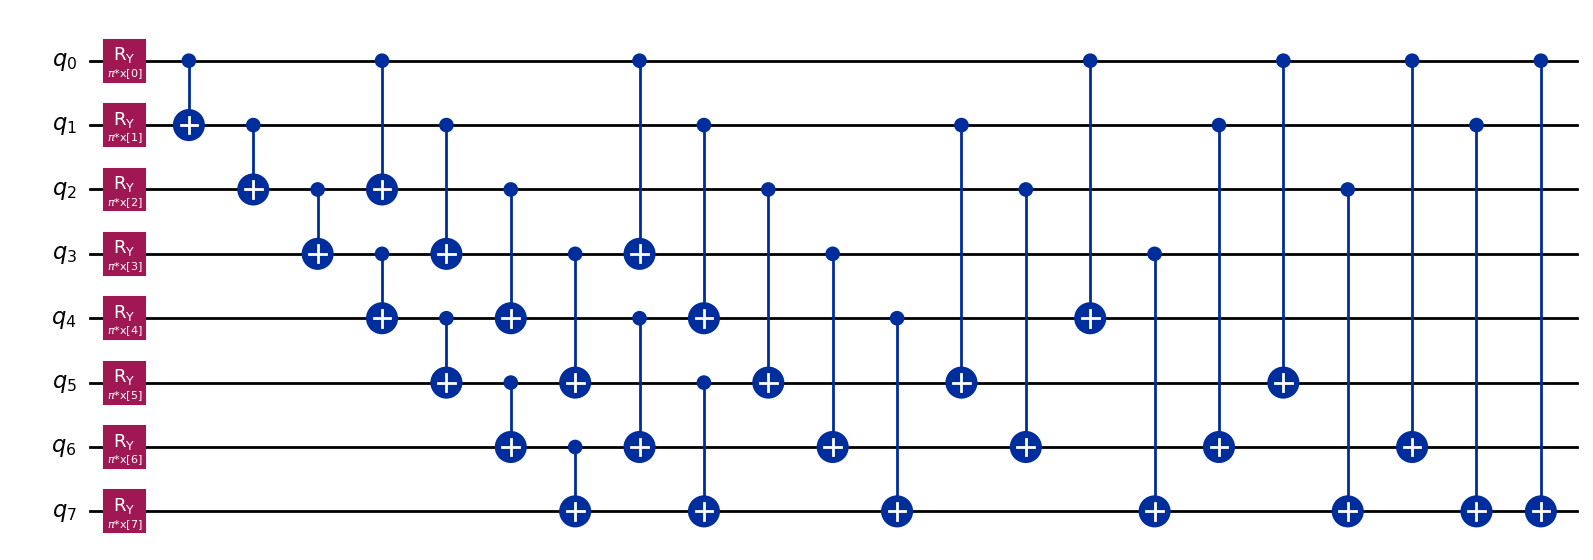

In [55]:
from ionqvision.ansatze.ansatz_library import AngleEncoder

numberDesiredParameters = 8
encoder = AngleEncoder(num_qubits=8, entanglement_depth=7)
encoder.draw("mpl")

To view the function's description (docstring), simply run the code cell `AngleEncoder?`. To examine its implementation, open the file `ionqvision/ansatze/ansatz_library` and find the `AngleEncoder` class.

Additionally, you can use its implementation as a template to create your own custom encoder designs!

In [56]:
AngleEncoder?

Init signature: AngleEncoder(num_qubits, entanglement_depth=1, param_prefix='x')
Docstring:     
Implement a quantum circuit for higher-order sparse angle encoding.

INPUT:

    - ``num_qubits`` -- number of qubits
    - ``entanglement_depth`` -- (optional) number layers of entangling CNOT
      gates: for each ``k`` in ``range(entanglement_depth)``, use gates
      ``CNOT(j, j + k + 1)``.
    - ``param_prefix`` -- (optional) string prefix for named circuit
      parameters

EXAMPLES::

    >>> from ionqvision.ansatze.ansatz_library import AngleEncoder
    >>> ansatz = AngleEncoder(4, entanglement_depth=3, param_prefix="y")
    >>> ansatz.draw()
         ┌────────────┐                              
    q_0: ┤ Ry(π*y[0]) ├──■──────────────■─────────■──
         ├────────────┤┌─┴─┐            │         │  
    q_1: ┤ Ry(π*y[1]) ├┤ X ├──■─────────┼────■────┼──
         ├────────────┤└───┘┌─┴─┐     ┌─┴─┐  │    │  
    q_2: ┤ Ry(π*y[2]) ├─────┤ X ├──■──┤ X ├──┼────┼──
         ├────────────

In [57]:
import numpy as np
import symengine as symeng

from math import ceil, log
from ionqvision.ansatze import VariationalAnsatz
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterExpression, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from ionqvision.ansatze.ansatz_library import BrickworkLayoutAnsatz, QCNNAnsatz

class QCNNAnsatzCustom(VariationalAnsatz):
    r"""
    Implement the Quantum Convolutional Network Ansatz (QCNN) as described in
    :cite:t:`2019:qcnn`.

    The quasi-local unitary $U_i$'s are entangling two-qubit gates with $6$
    variational parameters.
    They are laid out in a brickwork pattern with ``filter_depth`` layers.

    The pooling operations are implemented by two-qubit controlled rotations,
    with $2$ variational parameters.

    The circuit starts with ``num_qubits`` active qubits and then half the
    remaining qubits are discarded after each pooling operation until only a
    single active qubit remains. This final qubit is measured and the result is
    used for binary classification.
    """
    class ConvolutionBrickwork(BrickworkLayoutAnsatz):
        """
        Implement the convolution filters for the :class:`.QCNNAnsatz`.
        """
        def __init__(self, num_qubits, num_layers, prefix=None, qubits=None, initial_state=None):
            super().__init__(num_qubits, num_layers, blk_sz=3, prefix=prefix, qubits=qubits, initial_state=initial_state)
        
        def two_qubit_block(self, theta, q1, q2):
            conv_op = QuantumCircuit(2, name="CONV")
            conv_op.ry(theta[0], 0)
            conv_op.ry(theta[1], 1)
            conv_op.rxx(theta[2], 0, 1)
            self.append(conv_op.to_instruction(), [q1, q2])

    class PoolingLayer(BrickworkLayoutAnsatz):
        """
        Implement the pooling layer for the :class:`.QCNNAnsatz`.
        """
        def __init__(self, num_qubits, prefix=None, qubits=None):
            super().__init__(num_qubits, 1, blk_sz=1, prefix=prefix, qubits=qubits)
    
        def two_qubit_block(self, theta, q1, q2):
            pool_op = QuantumCircuit(2, name="POOL")
            pool_op.crz(theta[0], 1, 0)
            self.append(pool_op.to_instruction(), [q1, q2])

    def __init__(self, num_qubits, filter_depth=2, initial_state=None):
        num_layers = int(log(num_qubits, 2))
        if abs(log(num_qubits, 2) - num_layers) > 1e-6:
            raise ValueError("num_qubits must be a power of 2")

        super().__init__(num_qubits)
        if initial_state is not None:
            self.compose(initial_state, inplace=True)

        for k in range(num_layers):
            qubits = list(range(0, num_qubits, 2**k))
        
            conv = QCNNAnsatz.ConvolutionBrickwork(num_qubits, filter_depth, prefix="C" + str(k), qubits=qubits)
            self.compose(conv, inplace=True)
            
            pool = QCNNAnsatz.PoolingLayer(num_qubits, prefix="P" + str(k), qubits=qubits)
            self.compose(pool, inplace=True)

Similarly, you can utilize built-in options like the `BrickworkLayoutAnsatz` or the `QCNNAnsatz`, among others, for the trainable layer.

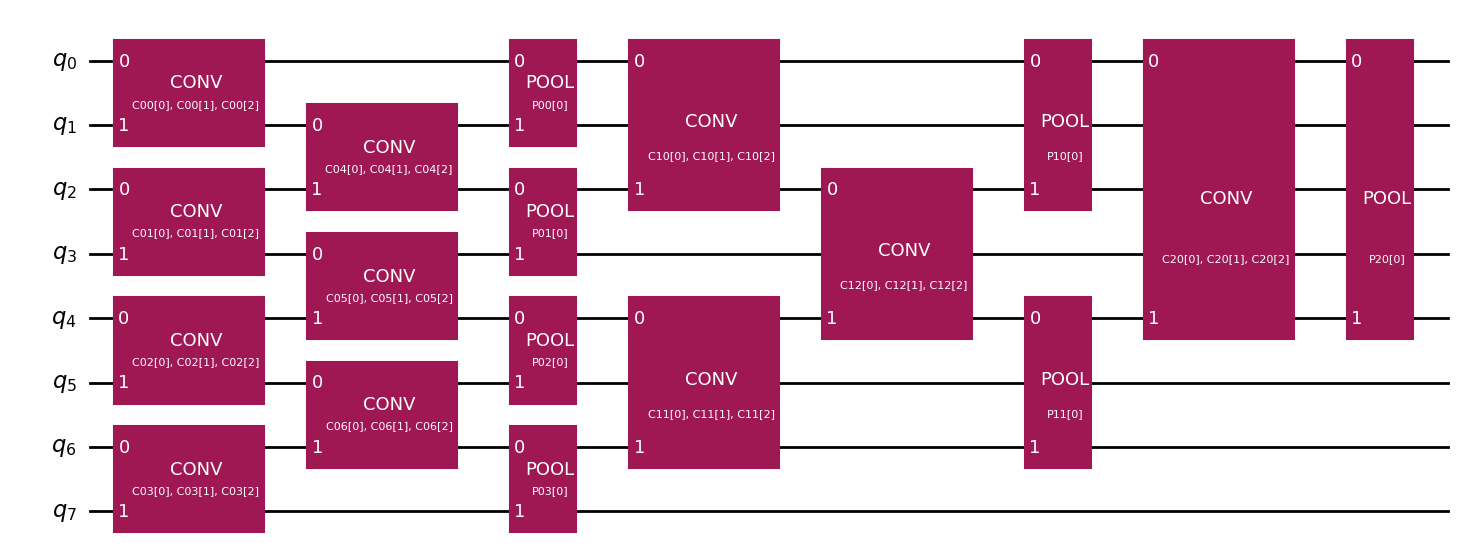

In [58]:
#from ionqvision.ansatze.ansatz_library import QCNNAnsatz

ansatz = QCNNAnsatzCustom(num_qubits=8)
ansatz.draw("mpl")

This ansatz is particularly intriguing as it features a sequence of "convolution" filters, interspersed with pooling operations that reduce the number of "active" qubits with each layer. Note that our implementation modifies [the original design](https://www.nature.com/articles/s41567-019-0648-8) by replacing mid-circuit measurements with controlled rotations.

If you're interested in using this ansatz, be sure to [subclass](https://pybit.es/articles/python-subclasses/) and implement your own `QCNNAnsatz.ConvolutionBrickwork` and `QCNN.PoolingLayer` modules!

```python
class QCNNAnsatz(VariationalAnsatz):
    r"""
    Implement the Quantum Convolutional Network Ansatz (QCNN) as described in
    :cite:t:`2019:qcnn`.

    The quasi-local unitary $U_i$'s are entangling two-qubit gates with $6$
    variational parameters.
    They are laid out in a brickwork pattern with ``filter_depth`` layers.

    The pooling operations are implemented by two-qubit controlled rotations,
    with $2$ variational parameters.

    The circuit starts with ``num_qubits`` active qubits and then half the
    remaining qubits are discarded after each pooling operation until only a
    single active qubit remains. This final qubit is measured and the result is
    used for binary classification.
    """
    class ConvolutionBrickwork(BrickworkLayoutAnsatz):
        """
        Implement the convolution filters for the :class:`.QCNNAnsatz`.
        """
        def __init__(self, num_qubits, num_layers, prefix=None, qubits=None, initial_state=None):
            super().__init__(num_qubits, num_layers, blk_sz=3, prefix=prefix, qubits=qubits, initial_state=initial_state)
        
        def two_qubit_block(self, theta, q1, q2):
            conv_op = QuantumCircuit(2, name="CONV")
            conv_op.ry(theta[0], 0)
            conv_op.ry(theta[1], 1)
            conv_op.rxx(theta[2], 0, 1)
            self.append(conv_op.to_instruction(), [q1, q2])

    class PoolingLayer(BrickworkLayoutAnsatz):
        """
        Implement the pooling layer for the :class:`.QCNNAnsatz`.
        """
        def __init__(self, num_qubits, prefix=None, qubits=None):
            super().__init__(num_qubits, 1, blk_sz=1, prefix=prefix, qubits=qubits)
    
        def two_qubit_block(self, theta, q1, q2):
            pool_op = QuantumCircuit(2, name="POOL")
            pool_op.crz(theta[0], 1, 0)
            self.append(pool_op.to_instruction(), [q1, q2])

    def __init__(self, num_qubits, filter_depth=2, initial_state=None):
        num_layers = int(log(num_qubits, 2))
        if abs(log(num_qubits, 2) - num_layers) > 1e-6:
            raise ValueError("num_qubits must be a power of 2")

        super().__init__(num_qubits)
        if initial_state is not None:
            self.compose(initial_state, inplace=True)

        for k in range(num_layers):
            qubits = list(range(0, num_qubits, 2**k))
        
            conv = QCNNAnsatz.ConvolutionBrickwork(num_qubits, filter_depth, prefix="C" + str(k), qubits=qubits)
            self.compose(conv, inplace=True)
            
            pool = QCNNAnsatz.PoolingLayer(num_qubits, prefix="P" + str(k), qubits=qubits)
            self.compose(pool, inplace=True)
```

Although <span style="color:purple">ionqvision</span> doesn’t offer built-in qubit observables, you can configure them using <span style="color:purple">Qiskit</span> with the following approach.

In [59]:
from qiskit.quantum_info import SparsePauliOp

# Measure the expectation value of X_0, Y_0, Z_0
quantum_features = [
    SparsePauliOp(["IIIX"]), 
    SparsePauliOp(["IIIY"]), 
    SparsePauliOp(["IIIZ"])
]

Keep in mind that the encoder, ansatz, and quantum feature vector are closely interconnected: how you embed latent vectors into the (multi-)qubit state space should influence how you transform the encoded state vectors, which in turn should guide the features you choose to measure.

The most effective model will likely leverage synergies from the deliberate co-design of these three components.

<div class="alert alert-block alert-info">
<b>⚡️ Important</b> <br>
This is your chance to unleash your creativity! Think outside the box and show us what you can do. Don’t hesitate to tap into the vast resources available online and use everything at your disposal.
</div>

### 🎹 Classical post-processing

After the quantum layer, the feature vectors in the classification pipeline are transferred back to the classical device for post-processing. Specifically, we train a fully-connected layer with a scalar output to minimize the binary [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy) between the final prediction and the true label of the input image. As before, dropout is applied during training, and the sigmoid [activation function](https://en.wikipedia.org/wiki/Activation_function) is used.

<p style="text-align: center;"><img src="./IonQCV/classical_post.png" alt="Classical post-processing" width="50%"/></p>

This final stage is intentionally light, to ensure the quantum layer is the star of the show.

<div class="alert alert-block alert-warning"><span style="color:black">
<b>⚠️ Note:</b> <br>
This part of the architecture is completely <b>fixed</b>: the input dimension <i>(m)</i> is determined by the quantum feature vector, and the output is always a scalar.</span>
</div>

## 🚂 Training your model

Once you've finalized your quantum layer, you can sit back and let <span style="color:purple">ionqvision</span> handle the heavy lifting. Start by setting up your classifier and ensuring everything functions as expected.

In [60]:
#from ionqvision.modules import BinaryMNISTClassifier

# Set up your classifier and inspect its architecture
#print(numberDesiredParameters)
#print("--------------------------------------------------")
#print(encoder)
#print("--------------------------------------------------")
#print(ansatz)
#print("--------------------------------------------------")
#print(quantum_features)
classifier = BinaryMNISTClassifier(numberDesiredParameters, encoder, ansatz, quantum_features); classifier


BinaryMNISTClassifier(
  (latent_vec_encoder): Sequential(
    (0): Linear(in_features=168, out_features=8, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
  (quantum_layer): QuantumModule()
  (prediction_head): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
)

By default, `qiskit` will print numerous `INFO` messages about passed tests. To suppress these messages, run the following code.

In [61]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

If you're wondering, `BinaryMNISTClassifier` is a standard `torch.nn.Module`. At this stage, all the parameters in your quantum layer have been registered with `Torch`, and autograd will automatically compute the necessary gradients during the backward pass. There's nothing else to worry about!

Make sure to check out the IonQ Vision Docs for more details on the inner workings of `BinaryMNISTClassifier` and related classes.

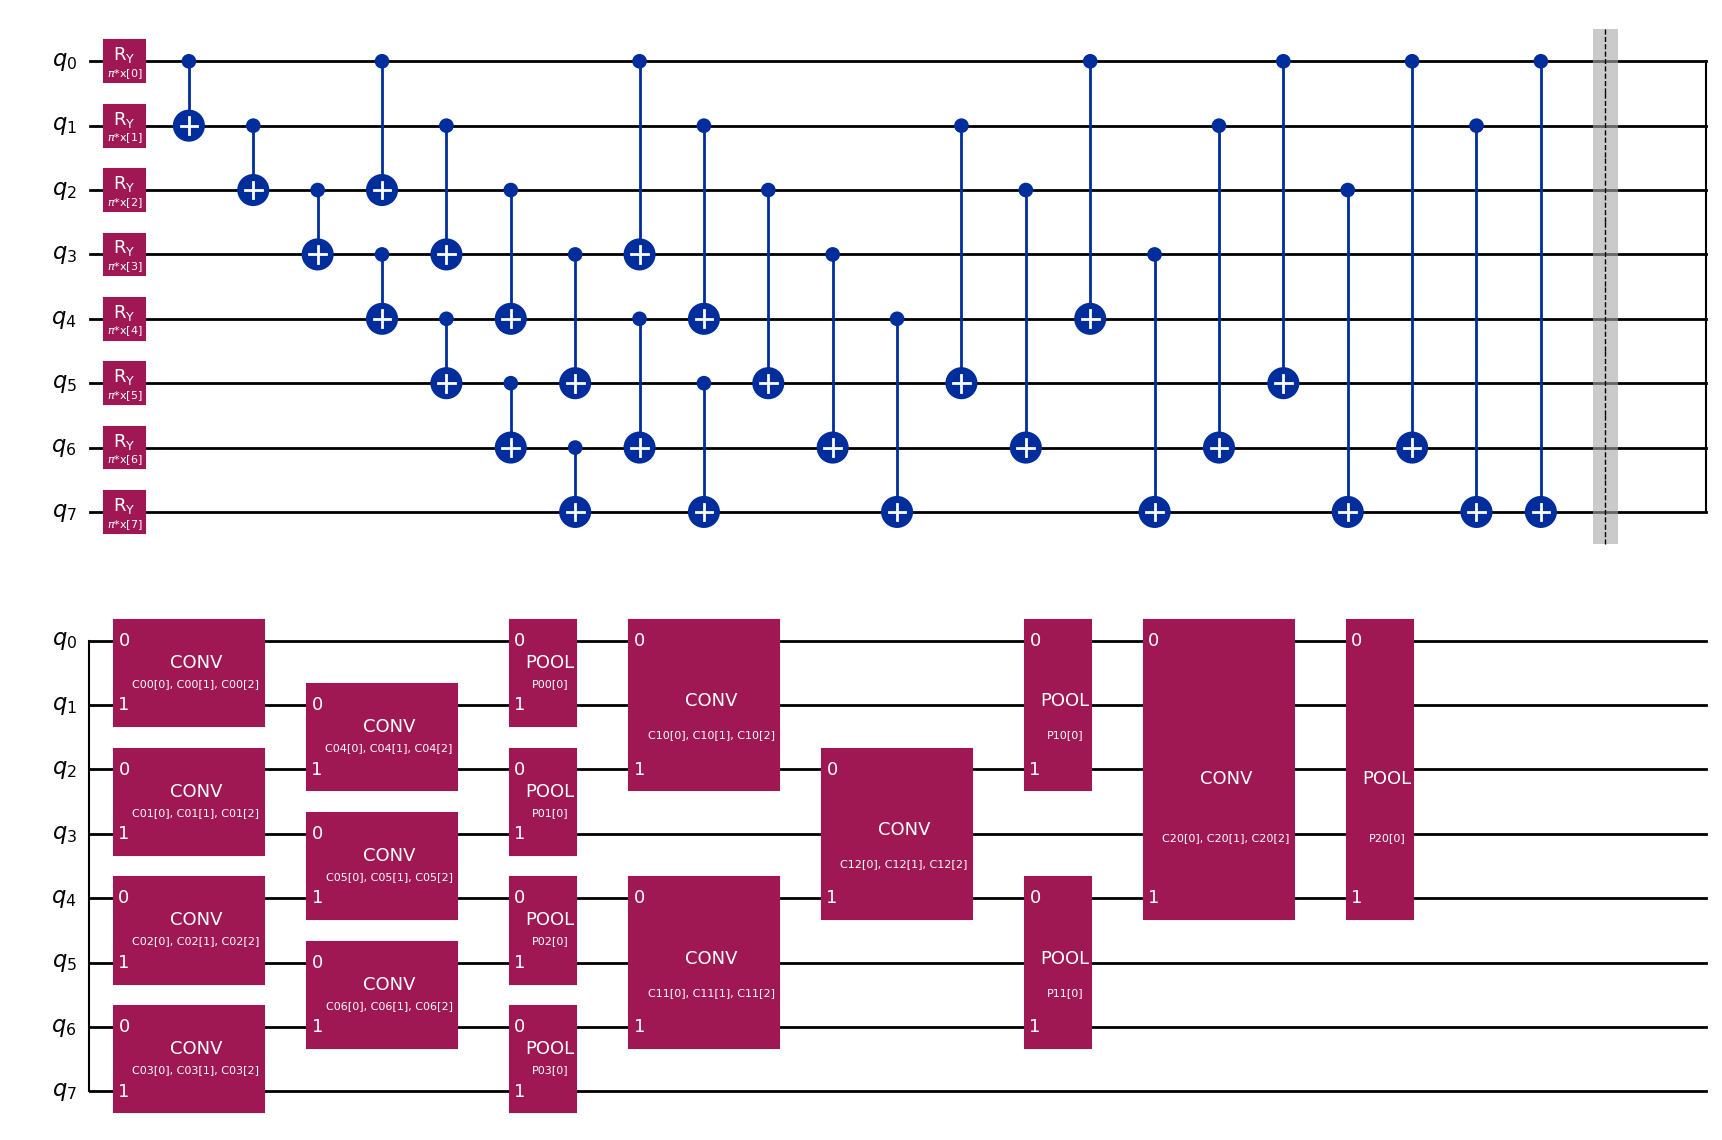

In [62]:
# Check out your quantum layer
classifier.quantum_layer.layer_qc.draw("mpl")

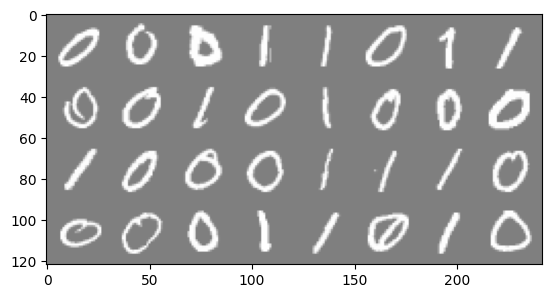

In [63]:
# Verify the images loaded correctly
classifier.visualize_batch()

Now train your model. Use the `config` dictionary to control lower-level aspects of the training, like the number of `epochs`, the learning rate `lr`, the `betas` used by [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), etc.

In [64]:
%%time
# Get a (pre-processed) training and test set
train_set, test_set = classifier.get_train_test_set(train_size=1000, test_size=100)

# Configure model training hyper parameters
config = {
    "epochs": 3,
    "lr": 0.1,
    "batch_size": 64,
    "betas": (0.9, 0.99),
    "weight_decay": 1e-3,
    "clip_grad": True,
    "log_interval": 1,
}

# Train and plot the results
classifier.train_module(train_set, test_set, config)
classifier.plot_training_progress()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 8)

The model achieved '55.00%' on the training set and '58.00%' on the test set.

## Submitting your model for grading

We've integrated the scoring system into the qBraid platform. To submit your model, you'll need to first initialize a qBraid session and set up the IonQ/SCQ client.

In [1]:
from qbraid.runtime import QbraidSession
from ionqvision.scq_client import IonQSCQClient

session = QbraidSession()

client = IonQSCQClient(session=session)

Now comes the exciting part! Use your classifier’s `submit_model_for_grading` method to submit your model for evaluation.

Your quantum layer and the trained weights will be serialized and then reassembled in a secure environment. We'll run inference on an unseen validation set using the reconstructed model to calculate your accuracy score.


In [3]:
submission_data = classifier.submit_model_for_grading(client=client)

message = submission_data.get("message")
submission_id = submission_data.get("submissionId")

#print(message)

NameError: name 'classifier' is not defined

It may take sometime to process the results.

In [22]:
client.await_autograder_result(submission_id=submission_id)

{'_id': '67097a4347318e44abf6d11f',
 'submittedBy': 'eppatten@ncsu.edu',
 'status': 'succeeded',
 'statusMessage': 'Submission graded successfully.',
 'executionId': 'ionq-scquantum-q6h87',
 'executionSec': 62,
 'score': 61,
 'createdAt': '2024-10-11T19:19:32.473Z',
 'updatedAt': '2024-10-11T19:19:32.473Z',
 'success': True}


After a few minutes, check [the live leaderboard](https://account.qbraid.com/hackathons/2024/scquantum) to see how your team ranks!

🍀 Good luck! We hope you have a great time tackling this exciting challenge.🤞 🥳 🎉

# 👉 [The real-time leaderboard](https://account.qbraid.com/hackathons/2024/scquantum)

Click the link above to know how you scored.

## Challenge submission

The autograder and live leaderboard are just one piece of your overall challenge submission. Make sure to submit your final model to the autograder at the end of the challenge period, as well as submitting your work-in-progress models throughout the challenge. Your score will be based on your final model's accuracy, as well as your active participation in the leaderboard and demonstration of progress throughout the challenge.

In addition to scoring your final model via the autograder, you'll need to:
* Submit a BUIDL on DoraHacks with a description of your challenge.
* Submit the code for your model: this should be a Jupyter notebook (you can start from this notebook or create a new one) but may also contain other files. It should include the code for building and training your model. You can create a GitHub repo for your code and link it to your BUIDL (just don't share the `ionqvision` source code in a public repo!) or you can check with the IonQ team for other options.
* Present your model for the judges.

See [the IonQ Challenge page on DoraHacks](https://dorahacks.io/hackathon/scquantathonv1/ionq-challenge#submission-and-judging) for more details and the most up-to-date information on submission and judging!